In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torchvision.models as models
from efficientnet_pytorch import EfficientNet

import os

from PIL import Image

In [2]:
root = os.getcwd() + '/root'
images_folder = root + '/images'
train_dir = root + '/train'
test_dir = root + '/test'

### Load data and transform

In [3]:
train_tfms = transforms.Compose([
                            transforms.Resize((224,224)),
                            transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
                            transforms.RandomHorizontalFlip(),
                            transforms.ToTensor(),
                            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                        ])

val_tfms = transforms.Compose([
                            transforms.Resize((224,224)),
                            transforms.ToTensor(),
                            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                        ])
image_datasets = {
    'train': torchvision.datasets.ImageFolder(train_dir, transform=train_tfms),
    'validation': torchvision.datasets.ImageFolder(test_dir, transform=val_tfms)
}

dataloaders = {
    'train': torch.utils.data.DataLoader(image_datasets['train'], batch_size=16, shuffle=True, drop_last=True, num_workers=0),
    'validation': torch.utils.data.DataLoader(image_datasets['validation'], batch_size=16, shuffle=True, drop_last=True, num_workers=0)
}

### Setting up GPU

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
print(torch.cuda.get_device_name(device))

cuda:0
GeForce GTX 1060 with Max-Q Design


### Getting pre-trained weights and fix the model

In [5]:
model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=37).to(device)

Loaded pretrained weights for efficientnet-b0


In [6]:
model

EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        32, 8, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        8, 32, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        32, 16, kernel_size=

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

### Train the model

In [8]:
def train_model(model, criterion, optimizer, num_epochs=3):
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                _, preds = torch.max(outputs, 1)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(image_datasets[phase])
            epoch_acc = running_corrects.double() / len(image_datasets[phase])

            print('{} loss: {:.4f}, acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
    return model

In [11]:
model_trained = train_model(model, criterion, optimizer, num_epochs=10)

Epoch 1/10
----------
train loss: 0.2485, acc: 0.9174
validation loss: 0.8201, acc: 0.7953
Epoch 2/10
----------
train loss: 0.2395, acc: 0.9277
validation loss: 0.6838, acc: 0.8165
Epoch 3/10
----------
train loss: 0.1826, acc: 0.9395
validation loss: 0.7538, acc: 0.8161
Epoch 4/10
----------
train loss: 0.2027, acc: 0.9337
validation loss: 0.7481, acc: 0.8066
Epoch 5/10
----------
train loss: 0.2031, acc: 0.9343
validation loss: 0.7819, acc: 0.8120
Epoch 6/10
----------
train loss: 0.2004, acc: 0.9350
validation loss: 0.7308, acc: 0.8156
Epoch 7/10
----------
train loss: 0.1542, acc: 0.9484
validation loss: 0.7003, acc: 0.8278
Epoch 8/10
----------
train loss: 0.1452, acc: 0.9526
validation loss: 0.9371, acc: 0.7940
Epoch 9/10
----------
train loss: 0.1352, acc: 0.9582
validation loss: 0.8833, acc: 0.8120
Epoch 10/10
----------
train loss: 0.1630, acc: 0.9486
validation loss: 0.7991, acc: 0.8246


### Save and Load

In [20]:
!mkdir models

mkdir: cannot create directory ‘models’: File exists


In [28]:
torch.save(model_trained.state_dict(), 'models/weights_efficientnet_b0.h5')

In [6]:
model = EfficientNet.from_name('efficientnet-b0', num_classes=37).to(device)

model.load_state_dict(torch.load('models/weights_efficientnet_b0.h5'))

<All keys matched successfully>

### Make prediction

In [12]:
correct = 0
total = 0
with torch.no_grad():
    for images, labels in dataloaders['validation']:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 2218 test images: %f %%' % (100 * correct / total))

Accuracy of the network on the 2218 test images: 82.789855 %


In [13]:
nb_classes = 37

confusion_matrix = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for i, (inputs, classes) in enumerate(dataloaders['validation']):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

<AxesSubplot:>

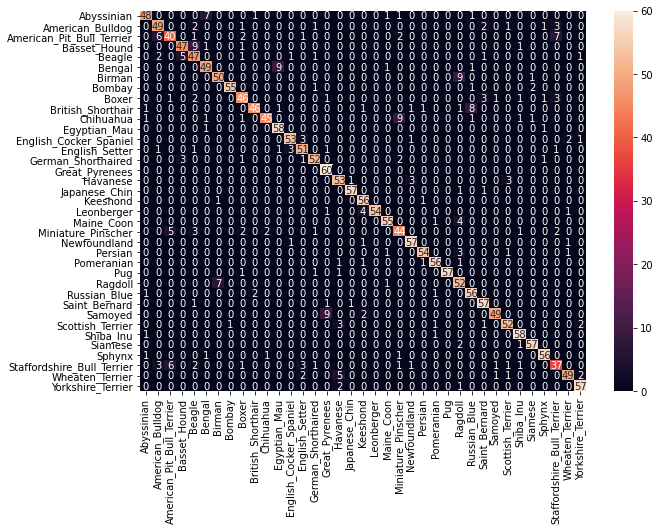

In [27]:
classes = image_datasets['train'].classes
df_cm = pd.DataFrame(confusion_matrix.numpy(), index=[i for i in classes],
                    columns=[i for i in classes])
plt.figure(figsize=(10,7))
sn.heatmap(df_cm, annot=True)

In [16]:
cm = confusion_matrix.numpy()
precision, recall = 0, 0
sum_row = np.sum(cm, axis=0)
sum_col = np.sum(cm, axis=1)
for i in range(37):
    precision = precision + cm[i][i] / sum_col[i]
    recall = recall + cm[i][i] / sum_row[i]
precision = precision / 37
recall = recall / 37

In [17]:
precision

0.8289085981008169

In [18]:
recall

0.8467613152555518

In [19]:
f1 = 2 * precision * recall / (precision + recall)
f1

0.8377398545619301